In [3]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *

BATCH_SIZE=128
IMAGE_SIZE=(64,64)
train_loader,val_loader=create_dataloader(IMAGE_SIZE,batch_size=BATCH_SIZE,bbox_out=False)
val_dataset = val_loader.dataset




In [18]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten the tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice
    
class RectangularLoss(nn.Module):
    def __init__(self):
        super(RectangularLoss, self).__init__()

    def forward(self, inputs):
        # Calculate the bounding box of the segmentation mask
        bounding_boxes = [self.calculate_bounding_box(output) for output in inputs]
        
        # Calculate the rectangular loss
        rect_loss = 0.0
        for output, bbox in zip(inputs, bounding_boxes):
            rect_loss += self.calculate_rectangular_loss(output, bbox)
        
        return rect_loss / len(inputs)

    def calculate_bounding_box(self, output, threshold=0.5):
        output = output.squeeze().cpu().detach().numpy()
        binary_mask = output > threshold
        coords = np.column_stack(np.where(binary_mask))
        if coords.size == 0:
            return [0, 0, 0, 0]  # No segmentation found
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        return [x_min, y_min, x_max, y_max]

    def calculate_rectangular_loss(self, output, bbox):
        x_min, y_min, x_max, y_max = bbox
        rect_mask = torch.zeros_like(output)
        rect_mask[:, y_min:y_max+1, x_min:x_max+1] = 1
        return nn.functional.mse_loss(output, rect_mask)

class CombinedLoss(nn.Module):
    def __init__(self, dice_loss, rectangular_loss, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = dice_loss
        self.rectangular_loss = rectangular_loss
        self.alpha = alpha

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        print("dice_loss",dice_loss)
        rect_loss = self.rectangular_loss(inputs)
        print("rect_loss",rect_loss)
        return dice_loss + self.alpha * rect_loss

# Example usage
dice_loss = DiceLoss()
rectangular_loss = RectangularLoss()
combined_loss = CombinedLoss(dice_loss, rectangular_loss, alpha=0.5)


In [19]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)




Using cache found in /Users/anton_heden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [20]:
import torch
import train 
importlib.reload(train)
from train import training_loop




# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
loss_fn= DiceLoss()
unet_metrics=training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=14)


Starting training
Training on device mps


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Epoch 1/14: Train loss: 0.839, Train f1.: 0.161, Train accuracy: 0.891, Val. loss: 0.730, Val. f1.: 0.270 Val. accuracy: 0.814


100%|██████████| 12/12 [00:17<00:00,  1.44s/it]


Epoch 2/14: Train loss: 0.570, Train f1.: 0.431, Train accuracy: 0.915, Val. loss: 0.590, Val. f1.: 0.410 Val. accuracy: 0.901


100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Epoch 3/14: Train loss: 0.450, Train f1.: 0.551, Train accuracy: 0.952, Val. loss: 0.417, Val. f1.: 0.584 Val. accuracy: 0.958


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Epoch 4/14: Train loss: 0.382, Train f1.: 0.620, Train accuracy: 0.962, Val. loss: 0.397, Val. f1.: 0.604 Val. accuracy: 0.959


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 5/14: Train loss: 0.340, Train f1.: 0.661, Train accuracy: 0.967, Val. loss: 0.376, Val. f1.: 0.625 Val. accuracy: 0.958


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 6/14: Train loss: 0.314, Train f1.: 0.688, Train accuracy: 0.969, Val. loss: 0.353, Val. f1.: 0.648 Val. accuracy: 0.964


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 7/14: Train loss: 0.287, Train f1.: 0.715, Train accuracy: 0.972, Val. loss: 0.364, Val. f1.: 0.637 Val. accuracy: 0.958


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 8/14: Train loss: 0.271, Train f1.: 0.730, Train accuracy: 0.973, Val. loss: 0.347, Val. f1.: 0.655 Val. accuracy: 0.967


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 9/14: Train loss: 0.257, Train f1.: 0.745, Train accuracy: 0.975, Val. loss: 0.326, Val. f1.: 0.675 Val. accuracy: 0.970


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Epoch 10/14: Train loss: 0.246, Train f1.: 0.755, Train accuracy: 0.976, Val. loss: 0.320, Val. f1.: 0.682 Val. accuracy: 0.971


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Epoch 11/14: Train loss: 0.230, Train f1.: 0.772, Train accuracy: 0.978, Val. loss: 0.313, Val. f1.: 0.688 Val. accuracy: 0.972


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Epoch 12/14: Train loss: 0.217, Train f1.: 0.785, Train accuracy: 0.979, Val. loss: 0.307, Val. f1.: 0.694 Val. accuracy: 0.972


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Epoch 13/14: Train loss: 0.208, Train f1.: 0.794, Train accuracy: 0.980, Val. loss: 0.306, Val. f1.: 0.695 Val. accuracy: 0.971


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Epoch 14/14: Train loss: 0.196, Train f1.: 0.806, Train accuracy: 0.981, Val. loss: 0.309, Val. f1.: 0.692 Val. accuracy: 0.973


Using cache found in /Users/anton_heden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Starting training
Training on device mps


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9522, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3178, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:16,  1.47s/it]

dice_loss tensor(0.9617, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3555, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9504, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3450, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.42s/it]

dice_loss tensor(0.9658, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3567, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

dice_loss tensor(0.9385, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3507, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.42s/it]

dice_loss tensor(0.9768, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3460, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.43s/it]

dice_loss tensor(0.9492, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3676, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9633, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3664, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.42s/it]

dice_loss tensor(0.9677, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3415, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

dice_loss tensor(0.9805, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3893, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.41s/it]

dice_loss tensor(0.9646, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3139, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.42s/it]

dice_loss tensor(0.9825, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3896, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9833, device='mps:0')
rect_loss tensor(0.0295, device='mps:0')
dice_loss tensor(0.9916, device='mps:0')
rect_loss tensor(0.0382, device='mps:0')
dice_loss tensor(0.9934, device='mps:0')
rect_loss tensor(0.0697, device='mps:0')
dice_loss tensor(0.9998, device='mps:0')
rect_loss tensor(0.0298, device='mps:0')
Epoch 1/14: Train loss: 1.316, Train f1.: 0.037, Train accuracy: 0.913, Val. loss: 1.034, Val. f1.: 0.008 Val. accuracy: 0.949


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9469, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3518, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.44s/it]

dice_loss tensor(0.9586, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3457, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.44s/it]

dice_loss tensor(0.9674, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3900, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:13,  1.45s/it]

dice_loss tensor(0.9739, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3641, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.43s/it]

dice_loss tensor(0.9595, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3092, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.41s/it]

dice_loss tensor(0.9717, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3231, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9676, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3688, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.41s/it]

dice_loss tensor(0.9670, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3453, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9636, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3475, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

dice_loss tensor(0.9560, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3533, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

dice_loss tensor(0.9360, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3496, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.42s/it]

dice_loss tensor(0.9650, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3334, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9660, device='mps:0')
rect_loss tensor(0.2224, device='mps:0')
dice_loss tensor(0.9750, device='mps:0')
rect_loss tensor(0.2259, device='mps:0')
dice_loss tensor(0.9806, device='mps:0')
rect_loss tensor(0.2262, device='mps:0')
dice_loss tensor(0.9796, device='mps:0')
rect_loss tensor(0.2195, device='mps:0')
Epoch 2/14: Train loss: 1.310, Train f1.: 0.039, Train accuracy: 0.913, Val. loss: 1.199, Val. f1.: 0.024 Val. accuracy: 0.930


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9476, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3586, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.41s/it]

dice_loss tensor(0.9838, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3579, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9195, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3145, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.41s/it]

dice_loss tensor(0.9649, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3401, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.40s/it]

dice_loss tensor(0.9760, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3693, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.39s/it]

dice_loss tensor(0.9751, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3430, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.40s/it]

dice_loss tensor(0.9780, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3753, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:06,  1.40s/it]

dice_loss tensor(0.9527, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3511, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.40s/it]

dice_loss tensor(0.9574, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3558, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.44s/it]

dice_loss tensor(0.9599, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3249, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.50s/it]

dice_loss tensor(0.9657, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3341, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.49s/it]

dice_loss tensor(0.9623, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3752, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


dice_loss tensor(0.9602, device='mps:0')
rect_loss tensor(0.3142, device='mps:0')
dice_loss tensor(0.9673, device='mps:0')
rect_loss tensor(0.2992, device='mps:0')
dice_loss tensor(0.9783, device='mps:0')
rect_loss tensor(0.3253, device='mps:0')
dice_loss tensor(0.9635, device='mps:0')
rect_loss tensor(0.3177, device='mps:0')
Epoch 3/14: Train loss: 1.312, Train f1.: 0.038, Train accuracy: 0.913, Val. loss: 1.281, Val. f1.: 0.033 Val. accuracy: 0.919


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9865, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3727, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.45s/it]

dice_loss tensor(0.9738, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.4134, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.44s/it]

dice_loss tensor(0.9509, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3587, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

dice_loss tensor(0.9502, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3569, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.46s/it]

dice_loss tensor(0.9682, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3664, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:10,  1.45s/it]

dice_loss tensor(0.9696, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3475, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.44s/it]

dice_loss tensor(0.9372, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3071, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:10<00:07,  1.44s/it]

dice_loss tensor(0.9542, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3387, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.45s/it]

dice_loss tensor(0.9556, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3365, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:13<00:04,  1.47s/it]

dice_loss tensor(0.9563, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3477, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.48s/it]

dice_loss tensor(0.9770, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3795, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:16<00:01,  1.48s/it]

dice_loss tensor(0.9644, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3617, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


dice_loss tensor(0.9592, device='mps:0')
rect_loss tensor(0.3429, device='mps:0')
dice_loss tensor(0.9653, device='mps:0')
rect_loss tensor(0.3296, device='mps:0')
dice_loss tensor(0.9776, device='mps:0')
rect_loss tensor(0.3313, device='mps:0')
dice_loss tensor(0.9535, device='mps:0')
rect_loss tensor(0.3577, device='mps:0')
Epoch 4/14: Train loss: 1.319, Train f1.: 0.038, Train accuracy: 0.913, Val. loss: 1.304, Val. f1.: 0.036 Val. accuracy: 0.915


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9638, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3319, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

dice_loss tensor(0.9663, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3174, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.42s/it]

dice_loss tensor(0.9617, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3539, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.42s/it]

dice_loss tensor(0.9674, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3364, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.41s/it]

dice_loss tensor(0.9593, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3485, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.42s/it]

dice_loss tensor(0.9486, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3492, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.43s/it]

dice_loss tensor(0.9670, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3625, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9549, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3594, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.42s/it]

dice_loss tensor(0.9637, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3364, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

dice_loss tensor(0.9759, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3992, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

dice_loss tensor(0.9491, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3433, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.42s/it]

dice_loss tensor(0.9584, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3994, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9581, device='mps:0')
rect_loss tensor(0.3573, device='mps:0')
dice_loss tensor(0.9643, device='mps:0')
rect_loss tensor(0.3493, device='mps:0')
dice_loss tensor(0.9767, device='mps:0')
rect_loss tensor(0.3508, device='mps:0')
dice_loss tensor(0.9500, device='mps:0')
rect_loss tensor(0.3627, device='mps:0')
Epoch 5/14: Train loss: 1.314, Train f1.: 0.039, Train accuracy: 0.913, Val. loss: 1.317, Val. f1.: 0.038 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9702, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3631, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.43s/it]

dice_loss tensor(0.9513, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3416, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.42s/it]

dice_loss tensor(0.9711, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3308, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.41s/it]

dice_loss tensor(0.9536, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3490, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.41s/it]

dice_loss tensor(0.9682, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3423, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.41s/it]

dice_loss tensor(0.9550, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3501, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9748, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3418, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9722, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3663, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9565, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3524, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.41s/it]

dice_loss tensor(0.9651, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3615, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.41s/it]

dice_loss tensor(0.9544, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3585, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.41s/it]

dice_loss tensor(0.9604, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3842, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9575, device='mps:0')
rect_loss tensor(0.3573, device='mps:0')
dice_loss tensor(0.9645, device='mps:0')
rect_loss tensor(0.3473, device='mps:0')
dice_loss tensor(0.9763, device='mps:0')
rect_loss tensor(0.3530, device='mps:0')
dice_loss tensor(0.9491, device='mps:0')
rect_loss tensor(0.3650, device='mps:0')
Epoch 6/14: Train loss: 1.316, Train f1.: 0.037, Train accuracy: 0.913, Val. loss: 1.317, Val. f1.: 0.038 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9645, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3957, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

dice_loss tensor(0.9632, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3220, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9590, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3779, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

dice_loss tensor(0.9616, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3548, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

dice_loss tensor(0.9619, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3153, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.42s/it]

dice_loss tensor(0.9482, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3344, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9539, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3315, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.41s/it]

dice_loss tensor(0.9715, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3890, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.40s/it]

dice_loss tensor(0.9724, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3365, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.41s/it]

dice_loss tensor(0.9499, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3424, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.40s/it]

dice_loss tensor(0.9830, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3675, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.40s/it]

dice_loss tensor(0.9420, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3756, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


dice_loss tensor(0.9571, device='mps:0')
rect_loss tensor(0.3593, device='mps:0')
dice_loss tensor(0.9641, device='mps:0')
rect_loss tensor(0.3493, device='mps:0')
dice_loss tensor(0.9760, device='mps:0')
rect_loss tensor(0.3457, device='mps:0')
dice_loss tensor(0.9481, device='mps:0')
rect_loss tensor(0.3650, device='mps:0')
Epoch 7/14: Train loss: 1.314, Train f1.: 0.039, Train accuracy: 0.913, Val. loss: 1.316, Val. f1.: 0.039 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9398, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3659, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.43s/it]

dice_loss tensor(0.9474, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3376, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9531, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3461, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

dice_loss tensor(0.9776, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3536, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

dice_loss tensor(0.9670, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3171, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:10,  1.43s/it]

dice_loss tensor(0.9718, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3470, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9698, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3736, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9749, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3430, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9546, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3324, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.43s/it]

dice_loss tensor(0.9689, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3364, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

dice_loss tensor(0.9578, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3612, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.43s/it]

dice_loss tensor(0.9647, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3437, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9571, device='mps:0')
rect_loss tensor(0.3574, device='mps:0')
dice_loss tensor(0.9638, device='mps:0')
rect_loss tensor(0.3493, device='mps:0')
dice_loss tensor(0.9760, device='mps:0')
rect_loss tensor(0.3495, device='mps:0')
dice_loss tensor(0.9479, device='mps:0')
rect_loss tensor(0.3650, device='mps:0')
Epoch 8/14: Train loss: 1.309, Train f1.: 0.038, Train accuracy: 0.912, Val. loss: 1.317, Val. f1.: 0.039 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9583, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3578, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.43s/it]

dice_loss tensor(0.9573, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3480, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.41s/it]

dice_loss tensor(0.9717, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3556, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.42s/it]

dice_loss tensor(0.9676, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3468, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.43s/it]

dice_loss tensor(0.9509, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3695, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.41s/it]

dice_loss tensor(0.9591, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3539, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9735, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3281, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.41s/it]

dice_loss tensor(0.9754, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3114, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9632, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3846, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.43s/it]

dice_loss tensor(0.9722, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3587, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.43s/it]

dice_loss tensor(0.9483, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3567, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.43s/it]

dice_loss tensor(0.9539, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3351, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9573, device='mps:0')
rect_loss tensor(0.3567, device='mps:0')
dice_loss tensor(0.9641, device='mps:0')
rect_loss tensor(0.3455, device='mps:0')
dice_loss tensor(0.9761, device='mps:0')
rect_loss tensor(0.3479, device='mps:0')
dice_loss tensor(0.9484, device='mps:0')
rect_loss tensor(0.3651, device='mps:0')
Epoch 9/14: Train loss: 1.313, Train f1.: 0.037, Train accuracy: 0.913, Val. loss: 1.315, Val. f1.: 0.039 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9716, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3338, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

dice_loss tensor(0.9537, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3464, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.45s/it]

dice_loss tensor(0.9599, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3461, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:13,  1.46s/it]

dice_loss tensor(0.9635, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3409, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.44s/it]

dice_loss tensor(0.9669, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3934, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:10,  1.44s/it]

dice_loss tensor(0.9703, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3526, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.44s/it]

dice_loss tensor(0.9593, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3938, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:10<00:07,  1.44s/it]

dice_loss tensor(0.9723, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3618, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.43s/it]

dice_loss tensor(0.9742, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3327, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

dice_loss tensor(0.9336, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3347, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

dice_loss tensor(0.9476, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3373, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.41s/it]

dice_loss tensor(0.9720, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3783, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


dice_loss tensor(0.9575, device='mps:0')
rect_loss tensor(0.3570, device='mps:0')
dice_loss tensor(0.9644, device='mps:0')
rect_loss tensor(0.3464, device='mps:0')
dice_loss tensor(0.9764, device='mps:0')
rect_loss tensor(0.3513, device='mps:0')
dice_loss tensor(0.9488, device='mps:0')
rect_loss tensor(0.3635, device='mps:0')
Epoch 10/14: Train loss: 1.316, Train f1.: 0.038, Train accuracy: 0.913, Val. loss: 1.316, Val. f1.: 0.038 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9549, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3651, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

dice_loss tensor(0.9532, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3174, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.44s/it]

dice_loss tensor(0.9755, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3881, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.44s/it]

dice_loss tensor(0.9653, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3544, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.43s/it]

dice_loss tensor(0.9711, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3735, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.43s/it]

dice_loss tensor(0.9745, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3567, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.43s/it]

dice_loss tensor(0.9537, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3769, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9442, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3060, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.43s/it]

dice_loss tensor(0.9702, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3829, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.43s/it]

dice_loss tensor(0.9708, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3489, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.43s/it]

dice_loss tensor(0.9728, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3537, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.43s/it]

dice_loss tensor(0.9325, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.2725, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


dice_loss tensor(0.9575, device='mps:0')
rect_loss tensor(0.3571, device='mps:0')
dice_loss tensor(0.9641, device='mps:0')
rect_loss tensor(0.3486, device='mps:0')
dice_loss tensor(0.9763, device='mps:0')
rect_loss tensor(0.3477, device='mps:0')
dice_loss tensor(0.9487, device='mps:0')
rect_loss tensor(0.3648, device='mps:0')
Epoch 11/14: Train loss: 1.311, Train f1.: 0.038, Train accuracy: 0.913, Val. loss: 1.316, Val. f1.: 0.039 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9725, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3654, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.44s/it]

dice_loss tensor(0.9690, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3833, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9674, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3678, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.42s/it]

dice_loss tensor(0.9478, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3103, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

dice_loss tensor(0.9682, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3597, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:09,  1.43s/it]

dice_loss tensor(0.9671, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3384, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.43s/it]

dice_loss tensor(0.9496, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3234, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.43s/it]

dice_loss tensor(0.9484, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3525, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.43s/it]

dice_loss tensor(0.9669, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3291, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

dice_loss tensor(0.9604, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.4043, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.43s/it]

dice_loss tensor(0.9495, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3197, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.43s/it]

dice_loss tensor(0.9775, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3548, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


dice_loss tensor(0.9573, device='mps:0')
rect_loss tensor(0.3588, device='mps:0')
dice_loss tensor(0.9640, device='mps:0')
rect_loss tensor(0.3515, device='mps:0')
dice_loss tensor(0.9761, device='mps:0')
rect_loss tensor(0.3515, device='mps:0')
dice_loss tensor(0.9484, device='mps:0')
rect_loss tensor(0.3623, device='mps:0')
Epoch 12/14: Train loss: 1.313, Train f1.: 0.038, Train accuracy: 0.913, Val. loss: 1.317, Val. f1.: 0.039 Val. accuracy: 0.913


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9709, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3347, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.43s/it]

dice_loss tensor(0.9451, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3606, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.42s/it]

dice_loss tensor(0.9520, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3596, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

dice_loss tensor(0.9750, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3556, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.43s/it]

dice_loss tensor(0.9591, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3017, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:10,  1.43s/it]

dice_loss tensor(0.9650, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3835, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.42s/it]

dice_loss tensor(0.9668, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3310, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

dice_loss tensor(0.9568, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3217, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9730, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3764, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.41s/it]

dice_loss tensor(0.9700, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3540, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.44s/it]

dice_loss tensor(0.9773, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3643, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.45s/it]

dice_loss tensor(0.9233, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3724, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


dice_loss tensor(0.9576, device='mps:0')
rect_loss tensor(0.3609, device='mps:0')
dice_loss tensor(0.9640, device='mps:0')
rect_loss tensor(0.3508, device='mps:0')
dice_loss tensor(0.9762, device='mps:0')
rect_loss tensor(0.3530, device='mps:0')
dice_loss tensor(0.9485, device='mps:0')
rect_loss tensor(0.3650, device='mps:0')
Epoch 13/14: Train loss: 1.312, Train f1.: 0.039, Train accuracy: 0.913, Val. loss: 1.319, Val. f1.: 0.039 Val. accuracy: 0.912


  0%|          | 0/12 [00:00<?, ?it/s]

dice_loss tensor(0.9825, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3523, device='mps:0', grad_fn=<DivBackward0>)


  8%|▊         | 1/12 [00:01<00:15,  1.44s/it]

dice_loss tensor(0.9612, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3449, device='mps:0', grad_fn=<DivBackward0>)


 17%|█▋        | 2/12 [00:02<00:14,  1.43s/it]

dice_loss tensor(0.9324, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3396, device='mps:0', grad_fn=<DivBackward0>)


 25%|██▌       | 3/12 [00:04<00:12,  1.44s/it]

dice_loss tensor(0.9677, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3542, device='mps:0', grad_fn=<DivBackward0>)


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

dice_loss tensor(0.9784, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3439, device='mps:0', grad_fn=<DivBackward0>)


 42%|████▏     | 5/12 [00:07<00:10,  1.43s/it]

dice_loss tensor(0.9461, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3277, device='mps:0', grad_fn=<DivBackward0>)


 50%|█████     | 6/12 [00:08<00:08,  1.43s/it]

dice_loss tensor(0.9613, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3465, device='mps:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 7/12 [00:09<00:07,  1.41s/it]

dice_loss tensor(0.9391, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3351, device='mps:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 8/12 [00:11<00:05,  1.41s/it]

dice_loss tensor(0.9650, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3555, device='mps:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 9/12 [00:12<00:04,  1.43s/it]

dice_loss tensor(0.9752, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3904, device='mps:0', grad_fn=<DivBackward0>)


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

dice_loss tensor(0.9714, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3774, device='mps:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 11/12 [00:15<00:01,  1.42s/it]

dice_loss tensor(0.9729, device='mps:0', grad_fn=<RsubBackward1>)
rect_loss tensor(0.3688, device='mps:0', grad_fn=<DivBackward0>)


100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


dice_loss tensor(0.9576, device='mps:0')
rect_loss tensor(0.3580, device='mps:0')
dice_loss tensor(0.9644, device='mps:0')
rect_loss tensor(0.3474, device='mps:0')
dice_loss tensor(0.9762, device='mps:0')
rect_loss tensor(0.3549, device='mps:0')
dice_loss tensor(0.9489, device='mps:0')
rect_loss tensor(0.3649, device='mps:0')
Epoch 14/14: Train loss: 1.316, Train f1.: 0.037, Train accuracy: 0.913, Val. loss: 1.318, Val. f1.: 0.038 Val. accuracy: 0.913


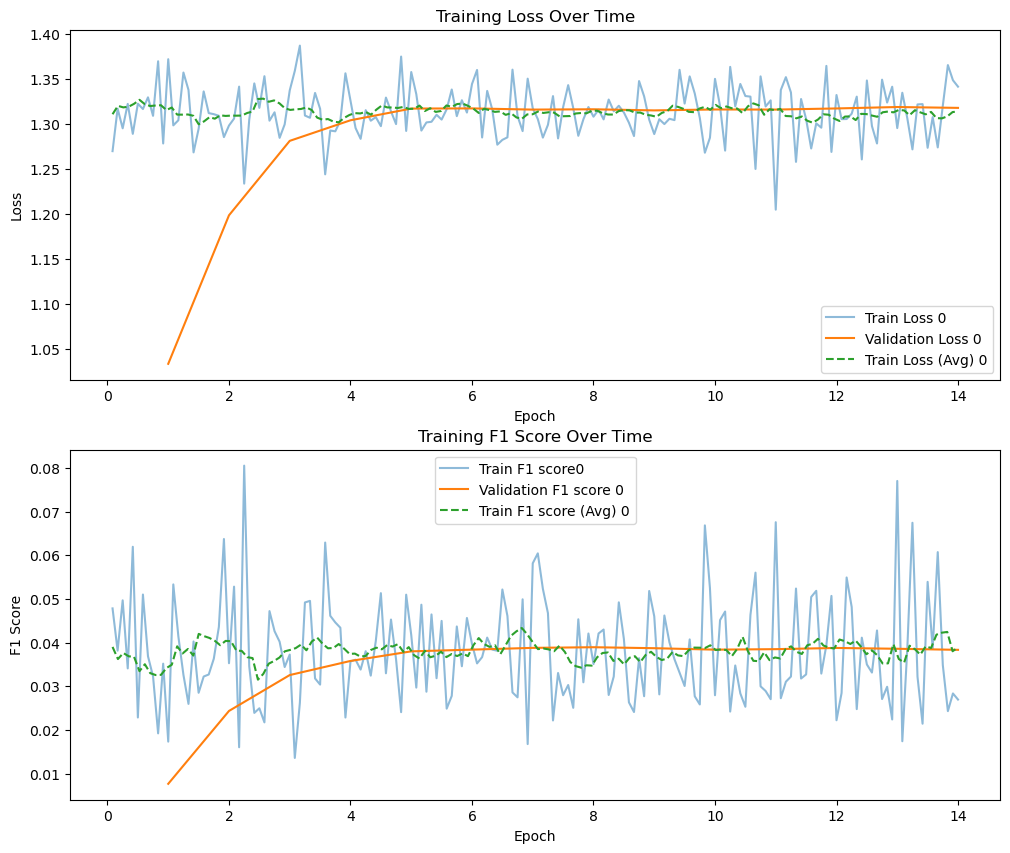

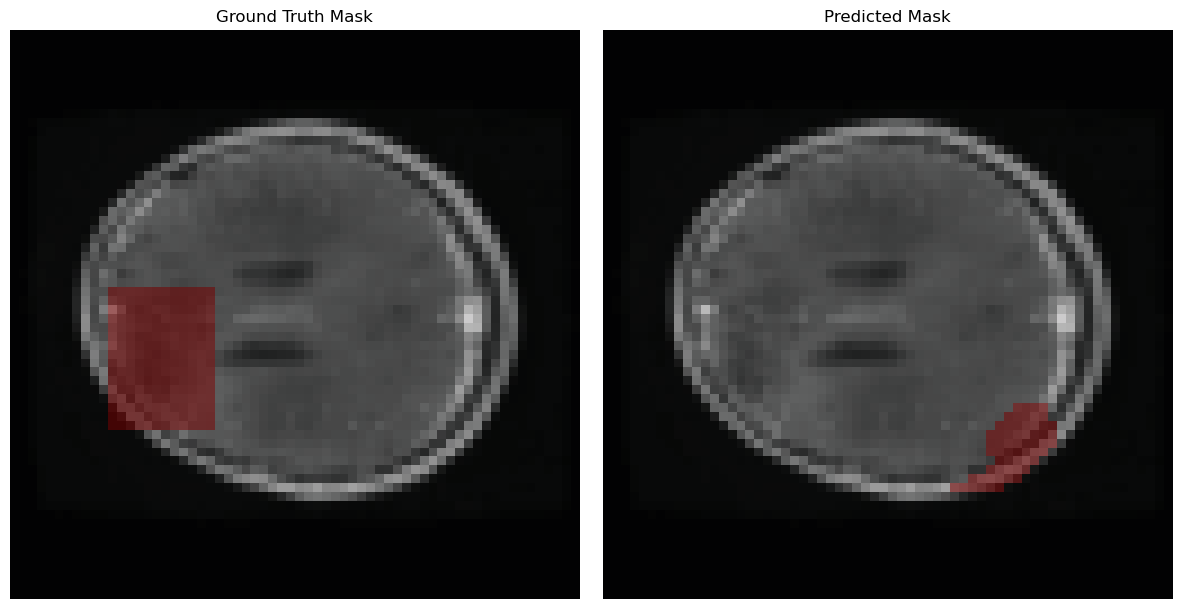

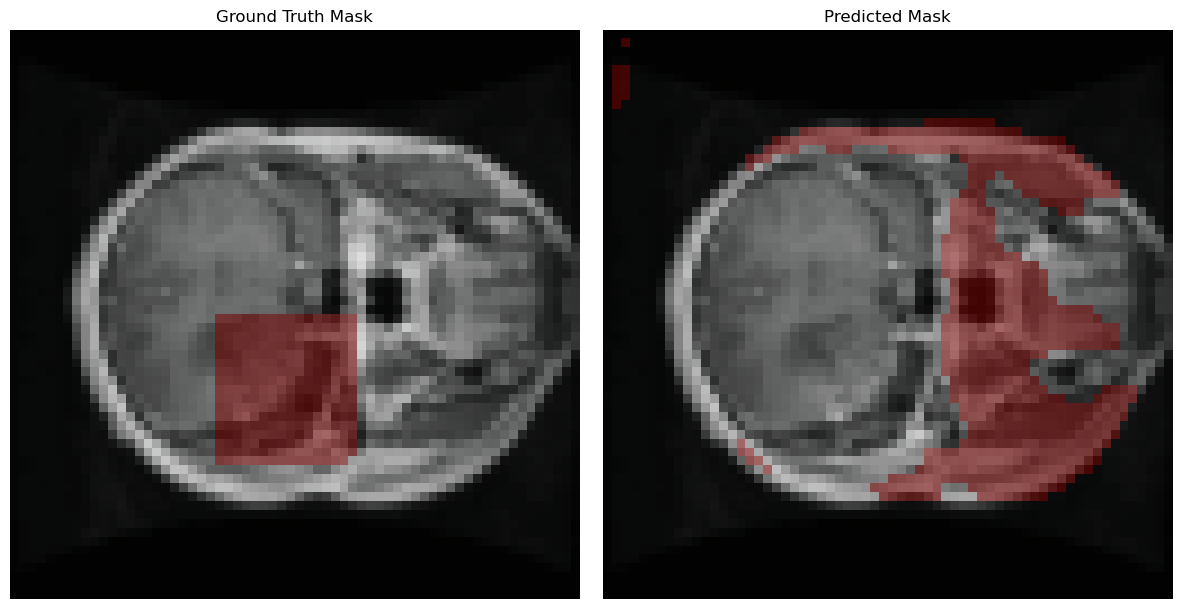

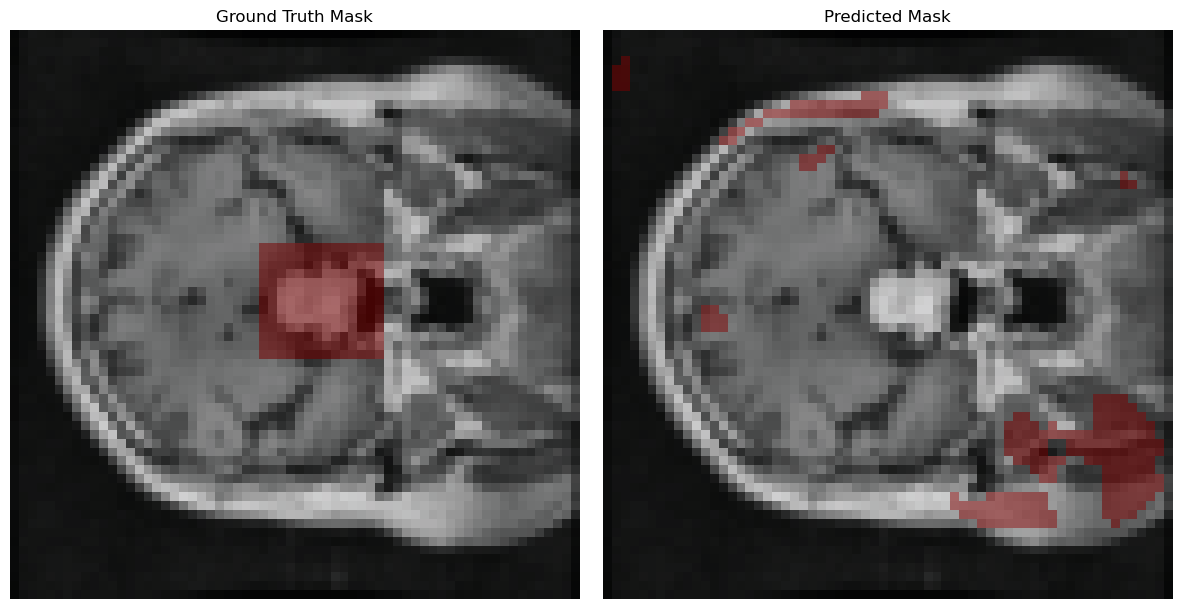

In [21]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
#save_model_to_file(unet_metrics, 'unet_brain2_seg.pth')


plot_performance_metrics([unet_metrics],batch_size=BATCH_SIZE)
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([0,1,2], val_dataset, unet_metrics[0])

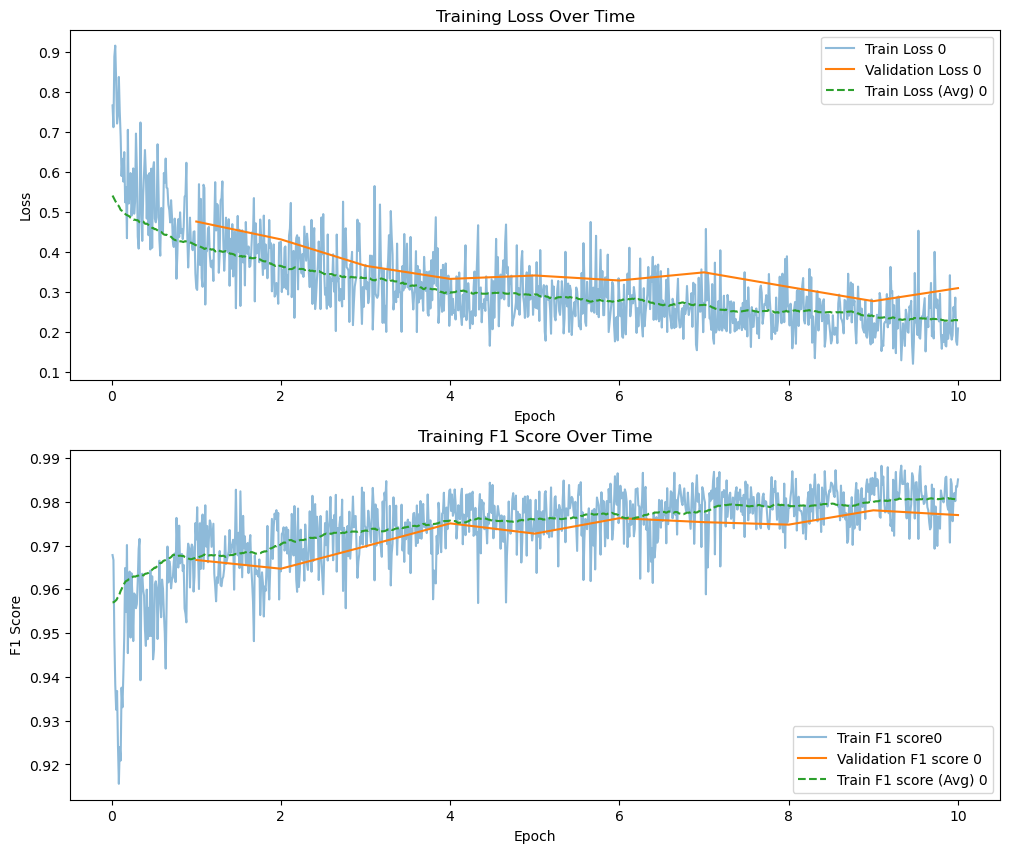

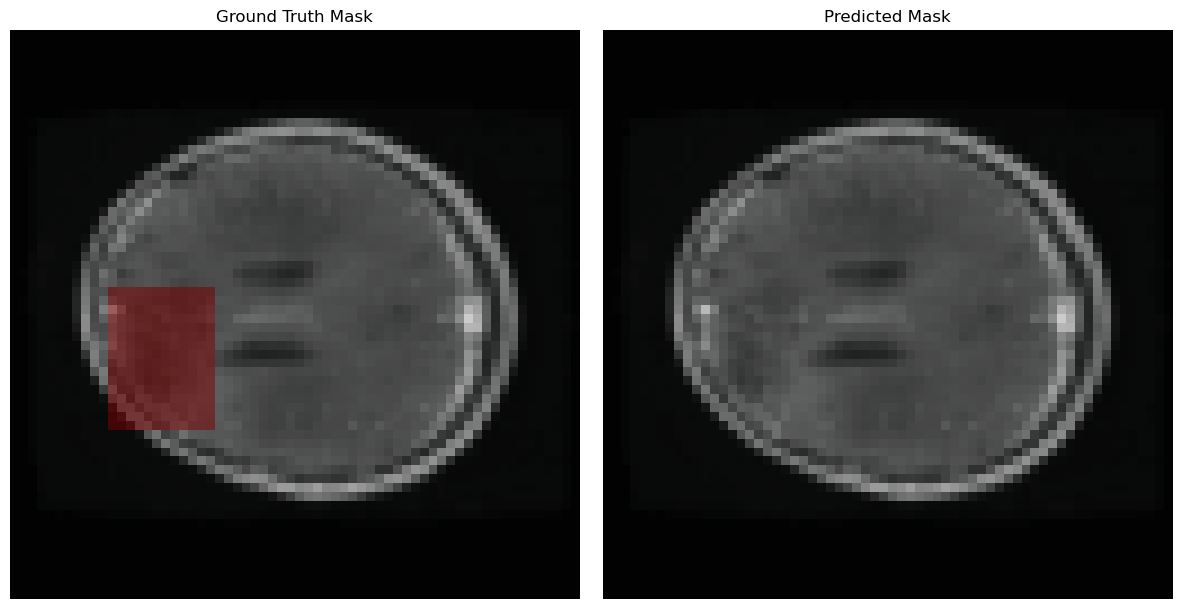

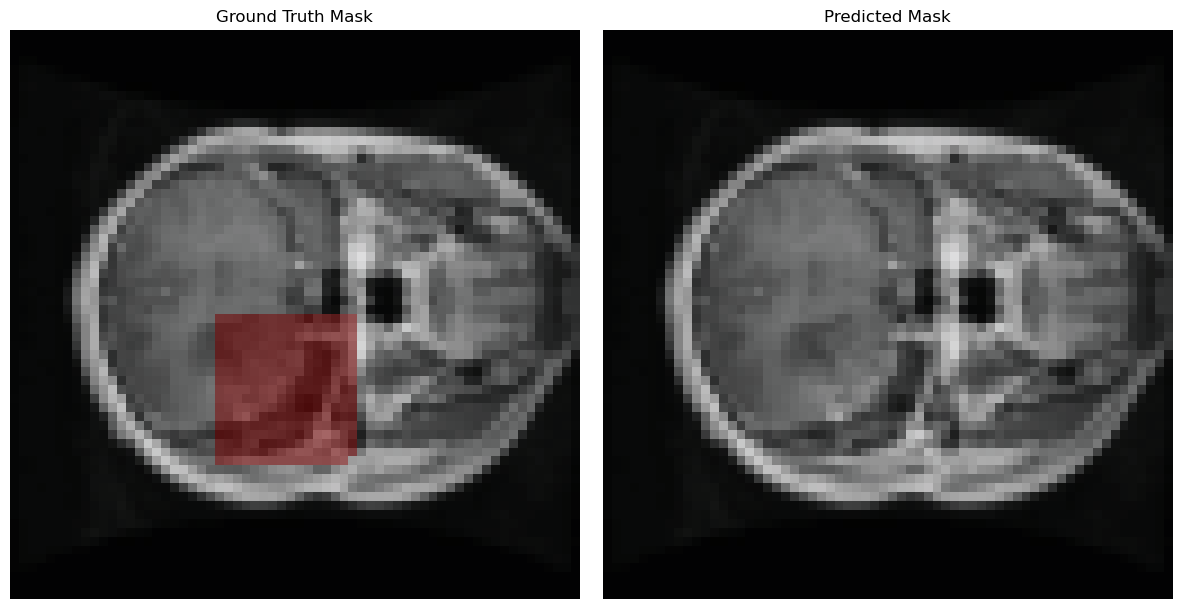

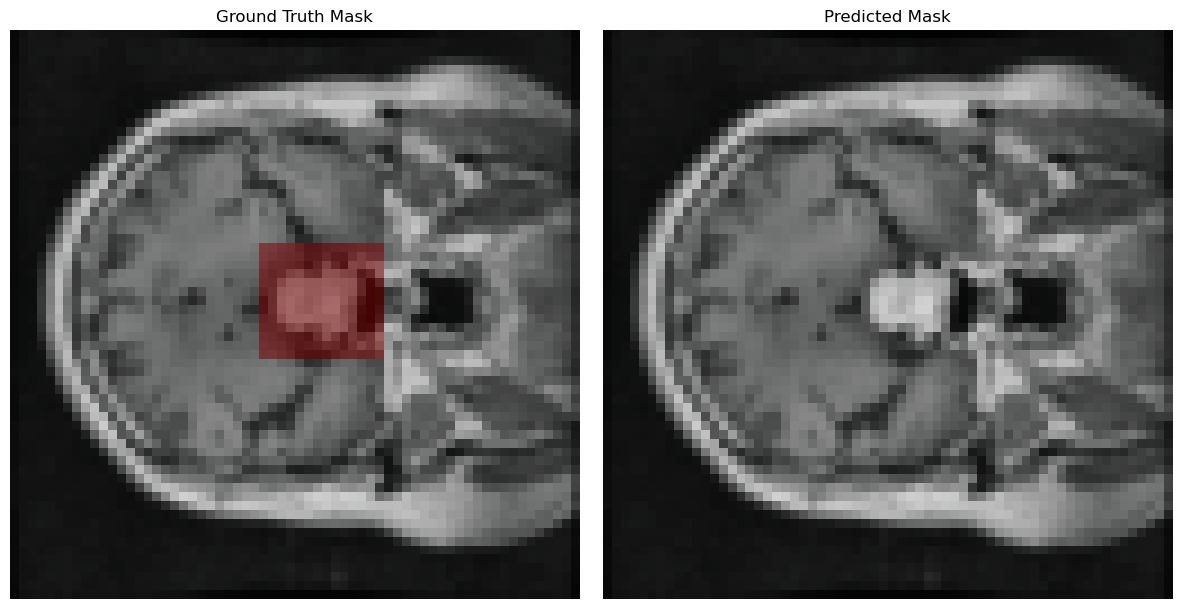

In [8]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
# Load the model and performance metrics
trained_metrics = get_model_and_performance_metrics("unet_brain_seg.pth", model)
plot_performance_metrics([trained_metrics],batch_size=16)

# Get the validation dataset
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([0,1,2], val_dataset, model)